Trains different algorithms for word embedding.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow import keras

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy

In [4]:

WINDOW = 3

DIM_EMBEDDING = 30

# Load data

In [5]:
import gensim.downloader as api

info = api.info() 

In [6]:
data_texts = api.load('text8')

In [7]:
text = [t for t in data_texts][:200]

In [8]:
len(text)

200

# Generate Dataset

Generates two different sets of data:

- **words**: only one word per row
- **contexts**:  2 * WINDOW words per row, indicating the context of the words

In [9]:
# text_as_words = text_to_word_sequence(text)
text_as_words = text

In [10]:
tok =  Tokenizer(3_000, oov_token=1)
tok.fit_on_texts(text_as_words)
id2word = {i: w for w, i in tok.word_index.items()}

NUMBER_WORDS = tok.num_words
print(NUMBER_WORDS, " palabras")

3000  palabras


In [11]:
id2word[0] = "[PAD]"

In [12]:
contexts = []
words = []

for t in text_as_words:
    for i in range(WINDOW, len(t) - WINDOW):
        words_in_context = t[i - WINDOW: i] + t[i+ 1: i + 1 + WINDOW]
        # tok_words_in_context = [tok.word_index[w] for w in words_in_context]
        tok_words_in_context = tok.texts_to_sequences(words_in_context)
        contexts.append(tok_words_in_context)
        words.append(tok.texts_to_sequences([t[i]])[0][0])

contexts = np.asarray(contexts)
words = np.asarray(words)

In [14]:
contexts = np.squeeze(contexts)

# Models

In [15]:
WORDS_FOR_TESTING = ["king", "small", "killed", "fast"]
IDS_WORDS_FOR_TESTING = tok.texts_to_sequences(WORDS_FOR_TESTING)

In [16]:
EPOCHS = 20

## CBOW Model

Given the words, predicts the context

In [3]:
from word2vec_models import CBOWModel

In [18]:
cbow_model = CBOWModel(DIM_EMBEDDING, NUMBER_WORDS)

2022-08-22 13:16:21.061621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-22 13:16:21.118488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-22 13:16:21.119146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-22 13:16:21.120643: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [19]:
cbow_model.compile("adam")

In [20]:
history_cbow = cbow_model.fit({"contexts":  contexts, "words": words}, epochs=EPOCHS, batch_size=64, shuffle=True, verbose=1)

Epoch 1/20
31232/31232 [==============================] - 127s 4ms/step - loss: 4.9274
Epoch 2/20
31232/31232 [==============================] - 134s 4ms/step - loss: 4.6327
Epoch 3/20
31232/31232 [==============================] - 148s 5ms/step - loss: 4.5272
Epoch 4/20
31232/31232 [==============================] - 157s 5ms/step - loss: 4.4705
Epoch 5/20
31232/31232 [==============================] - 151s 5ms/step - loss: 4.4376
Epoch 6/20
31232/31232 [==============================] - 152s 5ms/step - loss: 4.4175
Epoch 7/20
31232/31232 [==============================] - 149s 5ms/step - loss: 4.4050
Epoch 8/20
31232/31232 [==============================] - 147s 5ms/step - loss: 4.3965
Epoch 9/20
31232/31232 [==============================] - 149s 5ms/step - loss: 4.3907
Epoch 10/20
31232/31232 [==============================] - 150s 5ms/step - loss: 4.3867
Epoch 11/20
31232/31232 [==============================] - 146s 5ms/step - loss: 4.3839
Epoch 12/20
31232/31232 [================

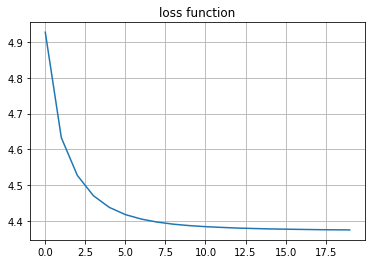

In [21]:
plt.plot(history_cbow.history["loss"])
plt.grid()
plt.title("loss function");

In [22]:
for id_, w in zip(IDS_WORDS_FOR_TESTING, WORDS_FOR_TESTING):
    print("\n", w)
    print("=================")
    best = cbow_model.get_closest_words(id_[0], n=10)
    for i, (best_word, score) in enumerate(best):
        print(f"{i + 1}): {id2word[best_word]}, similarity: {score}")
        


 king
1): king, similarity: 1
2): queen, similarity: 0.8718560934066772
3): son, similarity: 0.8512609601020813
4): prince, similarity: 0.8487167954444885
5): duke, similarity: 0.8210335969924927
6): emperor, similarity: 0.8031150698661804
7): sultan, similarity: 0.7968526482582092
8): pope, similarity: 0.7831507325172424
9): alexander, similarity: 0.7752802968025208
10): edward, similarity: 0.7632827758789062

 small
1): small, similarity: 1
2): large, similarity: 0.9073934555053711
3): huge, similarity: 0.798449695110321
4): smaller, similarity: 0.7567571997642517
5): massive, similarity: 0.7564603686332703
6): low, similarity: 0.7345193028450012
7): wide, similarity: 0.7311301231384277
8): narrow, similarity: 0.7188979983329773
9): significant, similarity: 0.6985927820205688
10): stable, similarity: 0.6866426467895508

 killed
1): killed, similarity: 1
2): defeated, similarity: 0.8481990694999695
3): fought, similarity: 0.7616397738456726
4): removed, similarity: 0.7561836242675781

## Skipgram Model

Given the contexts, predict the words

In [25]:
from word2vec_models import SkipgramModel

In [26]:
skipgram_model = SkipgramModel(DIM_EMBEDDING, NUMBER_WORDS)

In [28]:
skipgram_model.compile("adam")

In [29]:
history_skipgram = skipgram_model.fit({"contexts":  contexts, "words": words}, epochs=EPOCHS, batch_size=64, shuffle=True, verbose=1)

Epoch 1/20
31232/31232 [==============================] - 211s 7ms/step - loss: 0.2032
Epoch 2/20
31232/31232 [==============================] - 229s 7ms/step - loss: 0.1915
Epoch 3/20
31232/31232 [==============================] - 232s 7ms/step - loss: 0.1898
Epoch 4/20
31232/31232 [==============================] - 233s 7ms/step - loss: 0.1893
Epoch 5/20
31232/31232 [==============================] - 234s 7ms/step - loss: 0.1890
Epoch 6/20
31232/31232 [==============================] - 250s 8ms/step - loss: 0.1889
Epoch 7/20
31232/31232 [==============================] - 246s 8ms/step - loss: 0.1888
Epoch 8/20
31232/31232 [==============================] - 237s 8ms/step - loss: 0.1888
Epoch 9/20
31232/31232 [==============================] - 235s 8ms/step - loss: 0.1888
Epoch 10/20
31232/31232 [==============================] - 237s 8ms/step - loss: 0.1888
Epoch 11/20
31232/31232 [==============================] - 239s 8ms/step - loss: 0.1888
Epoch 12/20
31232/31232 [================

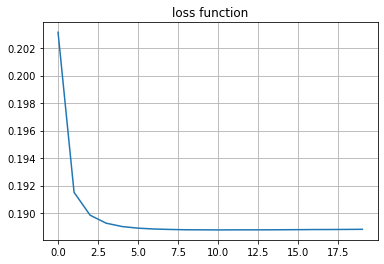

In [30]:
plt.plot(history_skipgram.history["loss"])
plt.grid()
plt.title("loss function");

In [31]:
for id_, w in zip(IDS_WORDS_FOR_TESTING, WORDS_FOR_TESTING):
    print("\n", w)
    print("=================")
    best = skipgram_model.get_closest_words(id_[0], n=10)
    for i, (best_word, score) in enumerate(best):
        print(f"{i + 1}): {id2word[best_word]}, similarity: {score}")
        
    


 king
1): king, similarity: 1
2): prince, similarity: 0.8771789073944092
3): son, similarity: 0.8686491847038269
4): iv, similarity: 0.8648770451545715
5): emperor, similarity: 0.8585812449455261
6): portugal, similarity: 0.84360671043396
7): vi, similarity: 0.819793701171875
8): philip, similarity: 0.8153389096260071
9): henry, similarity: 0.8078529238700867
10): daughter, similarity: 0.8059914708137512

 small
1): small, similarity: 1
2): large, similarity: 0.9219360947608948
3): smaller, similarity: 0.781589686870575
4): larger, similarity: 0.7442804574966431
5): relatively, similarity: 0.7369237542152405
6): huge, similarity: 0.7286206483840942
7): nearby, similarity: 0.7112388610839844
8): coastal, similarity: 0.6969974637031555
9): growing, similarity: 0.6742309331893921
10): massive, similarity: 0.6733440160751343

 killed
1): killed, similarity: 1
2): captured, similarity: 0.7723318338394165
3): sent, similarity: 0.7470306158065796
4): met, similarity: 0.7017348408699036
5): f

## Negative Sampling Model

When using both skipgram and cbow, all weights in the decoder must be updated once for each batch. The are `NUMBER_WORDS x SIZE_EMBEDDING` different weights, which typically is a huge number and makes training very slow.

Using negative sampling, the operations performed are:

- Compute embedding for words
- Compute embedding for context
- Compute cosine similarity of both
- Predict if word and context match together

In this way, only `SIZE_EMBEDDING x (2 * WINDOW_SIZE + 1)` weights need to be updated for each row.



In [32]:
from word2vec_models import NegativeSamplingModel

### Generator

In [33]:
NEGATIVE_RATE = 0.3

def data_generator(contexts, words, batch_size):
    batch_data = {"contexts": [], "words": [], "labels": []}
    
    while True:
        i_context = random.randrange(len(contexts))
        if random.uniform(0, 1) < NEGATIVE_RATE:
            i_word = random.randrange(len(words))
            target = 0
        else:
            i_word = i_context
            target = 1
        batch_data["words"].append(words[i_word])
        batch_data["contexts"].append(contexts[i_context, :])
        batch_data["labels"].append(target)
        
        if len(batch_data["labels"]) == batch_size:
            for k, v in batch_data.items():
                batch_data[k] = np.asarray(v)
                
           
            yield batch_data
            batch_data = {"contexts": [], "words": [], "labels": []}
            


### Model

In [40]:
negative_sampling_model = NegativeSamplingModel(DIM_EMBEDDING, NUMBER_WORDS, name="negative_sampling")
negative_sampling_model.compile("adam")

In [41]:
inputs = {"contexts": contexts[:5, :], "words": words[:5], "labels": np.zeros(5)}
predictions = negative_sampling_model(inputs)
negative_sampling_model.summary()

Model: "negative_sampling"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  90030     
                                                                 
 mean (GlobalAveragePooling1  multiple                 0         
 D)                                                              
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dot_2 (Dot)                 multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  2         
                                                                 
Total params: 90,034
Trainable params: 90,032
Non-trainable params: 2
_____________________________________________

In [42]:
BATCH_SIZE = 1024
STEPS_PER_EPOCH = len(contexts) // BATCH_SIZE

hisory_negative_sampling = negative_sampling_model.fit(data_generator(contexts, words, BATCH_SIZE), epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/20
1951/1951 [==============================] - 16s 8ms/step - loss: 0.5477
Epoch 2/20
1951/1951 [==============================] - 16s 8ms/step - loss: 0.5172
Epoch 3/20
1951/1951 [==============================] - 16s 8ms/step - loss: 0.5064
Epoch 4/20
1951/1951 [==============================] - 16s 8ms/step - loss: 0.5019
Epoch 5/20
1951/1951 [==============================] - 17s 9ms/step - loss: 0.4982
Epoch 6/20
1951/1951 [==============================] - 19s 10ms/step - loss: 0.4961
Epoch 7/20
1951/1951 [==============================] - 18s 9ms/step - loss: 0.4943
Epoch 8/20
1951/1951 [==============================] - 18s 9ms/step - loss: 0.4944
Epoch 9/20
1951/1951 [==============================] - 18s 9ms/step - loss: 0.4934
Epoch 10/20
1951/1951 [==============================] - 19s 9ms/step - loss: 0.4923
Epoch 11/20
1951/1951 [==============================] - 19s 10ms/step - loss: 0.4925
Epoch 12/20
1951/1951 [==============================] - 17s 9ms/step - 

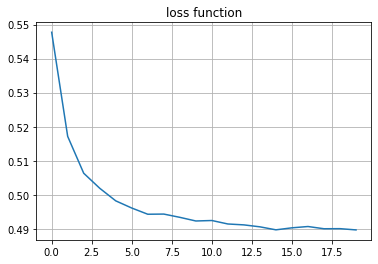

In [43]:
plt.plot(hisory_negative_sampling.history["loss"])
plt.grid()
plt.title("loss function");